# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Alini, Walter
- Salina, Noelia

### Mentora:

- Dal Lago, Virginia

### Práctico: Análisis exploratorio y curación

# Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

# Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.

# Objetivos generales

  * Realizar un estudio exploratorio del dataset para extraer información útil sobre el problema a resolver
  * Desarrollar visión crítica en relación a la problemática para llevar a cabo el procedimiento de ciencia de datos
  * Desarrollar habilidades de comunicación de la información obtenida a partir de los datos de manera clara y sencilla.

# Objetivos específicos

 - Desestimar los datos que se consideren que no aportan a la resolución del problema, a partir de las hipótesis que se incorporen, en términos de conocimiento del dominio y de confianza de los mismos.
 - Realizar las primeras pruebas de conversión y predicción de información, a partir de los datos con los que se cuentan y a partir de la información que se extraiga de ellos
 - Validar y, sobre todo, generar preguntas e hipótesis que ayuden a entender el problema en profundidad y desafíen el prejuicio y la percepción de aprendizaje de las nuevas problemáticas
 - Generar confianza en la manipulación y análisis de los datos específicos de la problemática

# Metodología

A lo largo de este trabajo trataremos de responder a las siguientes preguntas:

1. ¿Existen datos duplicados? ¿Con qué información deberíamos contar para poder determinar con certeza que dichos datos están duplicados y no corresponden a dos envíos diferentes?
1. En relación a las diferentes columnas de fechas, en el práctico anterior notamos que muchas de ellas no eran consistentes. Identificar y cuantificar los valores atípicos de cada columna. ¿Qué tipo de anomalías hay en el conjunto completo? ¿Qué deberíamos realizar con dichos datos?
1. Una información que, a futuro, podría ser relevante para modelar es el estado de Brasil al cual llega el envío. Sin embargo, esta información está codificada en la columna en formato de texto. ¿De qué maneras podríamos transformar la misma en valores numéricos para utilizar en un modelo? Mostrar al menos dos ejemplos.
1. A la hora de determinar la promesa de entrega de un envío (fecha estimada de llegada), ¿cuáles son los features que consideran pueden tener mayor relevancia? ¿Cuál es el valor a predecir?
1. Suponiendo que queremos emplear un modelo kNN para calcular la promesa de entrega de un envío. ¿Qué transformaciones sugieren realizar sobre los features antes seleccionados? Mostrar al menos un ejemplo.
1. Nos interesa determinar si un envío llegará entre 0-1 días, 2-3 días, 4-5 días, 6-7 días, 8-9 días ó 10 o más días. Construir una nueva columna en el dataset que indique a cuál de estos grupos pertence cada envío, y codificarla numéricamente, de manera tal de poder ser utilizada como valor a predecir. Seleccionar los dos features que se consideren de mayor relevancia para un modelo, y aplicar un procedimiento de clustering (separando en los grupos antes definidos).

Esta comunicación debe estar dirigida para un público técnico pero que desconoce los aspectos propios del problema a resolver (por ejemplo, sus compañeros de clase). Se evaluará, principalmente, la claridad del mensaje presentado, el uso de las herramientas y los conceptos desarrollados en las clases teóricas. 
Además se debe realizar una breve comunicación en pdf (2 páginas máximo) dirigida a un stakeholder del proyecto (por ejemplo, manager), comentando los hallazgos y problemas encontrados, y las posibles acciones a tomar. [Link al informe](https://docs.google.com/document/d/14g9r3kmdok-dE6SPlvgUdcy91-go_ew6NrVkZ2uSpUc/edit?ts=5d0bf339#heading=h.9035byhjqevf)

# Desarrollo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import special
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce # usar "pip install category_encoders" para instalar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import itertools

BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

RELATIVE_PATH = './'
DATA_FILE = 'dataset_sample_corrected.csv'

# Establecemos una semilla por cuestiones de reproducibilidad
np.random.seed(0)

In [2]:
# transform functions

def tf_receiver_state(df):
    """
    Returns the data frame df with 'receiver_state' column replaced by new columns obtained by 'receiver_state' binary encoding.
    """
    df['receiver_state_copy'] = df['receiver_state']
    encoder = ce.BinaryEncoder(cols=['receiver_state'])
    return encoder.fit_transform(df).rename(columns={'receiver_state_copy':'receiver_state'})

def tf_receiver_frequency(df):
    """
    Returns a data frame df with new column 'receiver_frequency' obtained by count the total amount of 
    shipments to each receiver state.
    """
    receiver_frequency_values = dataset.groupby('receiver_state')['receiver_state'].count().reset_index(name='receiver_frequency')
    return pd.merge(df, receiver_frequency_values, on = 'receiver_state', how='left')

def tf_receiver_zipcode(df,chars):
    """
    Returns the data frame df with a new column named 'tf_receiver_zipcode'.
    New column is filled with 'receiver_zipcode' with 'CHARS' amount of characters.
    If CHARS >= 5, tf_receiver_zipcode copies receiver_zipcode
    """
    if 'tf_receiver_zipcode' in df.columns:
        df = df.drop('tf_receiver_zipcode', axis=1)
    chars_to_drop = 5 - chars
    if chars_to_drop > 0:
        df['tf_receiver_zipcode'] = df['receiver_zipcode'].apply(lambda cell: int(str(cell)[:-chars_to_drop]))
    else:
        df['tf_receiver_zipcode'] = df['receiver_zipcode']
    return df

def tf_sender_zipcode(df,chars):
    """
    Returns the data frame df with a new column named 'tf_sender_zipcode'.
    New column is filled with 'sender_zipcode' with 'CHARS' amount of characters.
    If CHARS >= 5, tf_sender_zipcode copies sender_zipcode
    """
    if 'tf_sender_zipcode' in df.columns:
        df = df.drop('tf_sender_zipcode', axis=1)
    chars_to_drop = 5 - chars
    if chars_to_drop > 0:
        df['tf_sender_zipcode'] = df['sender_zipcode'].apply(lambda cell: int(str(cell)[:-chars_to_drop]))
    else:
        df['tf_sender_zipcode'] = df['sender_zipcode']
    return df

def tf_shipment_type(df):
    """
    Returns the data frame df with a new column named 'standard'.
    New column is filled with 1 if shiptment_type is 'standard', otherwise 0.
    'shipment_type' column is discarded
    """
    if 'standard' in df.columns:
        df = df.drop('standard', axis=1)
    df['standard'] = df['shipment_type'].apply(lambda cell: 1 if cell =='standard' else 0)
    return df

def tf_service(df):
    """
    Returns the data frame df with 'service' column replaced by new columns obtained by 'service' binary encoding.
    """
    encoder = ce.BinaryEncoder(cols=['service'])
    return encoder.fit_transform(df)

def encode_shipment_days(df):
    """
    Returns a data frame df with new column 'shipment_days_category' obtained by mapping shipment days to ranges 
    or categories defined by a dictionary.
    """
    if 'shipment_days_category' in df.columns:
        df = df.drop('shipment_days_category', axis=1)
    transform_list = [([0,1],'0_1'),
                      ([2,3],'2_3'),
                      ([4,5],'4_5'),
                      ([6,7],'6_7'),
                      ([8,9],'8_9'),
                      ([x for x in range(10,int(max(df['shipment_days']))+1)], '10_or_more')]
    for tuple_map in transform_list:
        df.loc[df['shipment_days'].isin(tuple_map[0]),'shipment_days_category'] = tuple_map[1]
    return df

def tf_shipment_days(df):
    """
    Returns the data frame df with 'shipment_days_category' column replaced by new columns obtained by 
    'shipment_days_category' binary encoding.
    """
    transform_dict = {'0_1' : 0,
                      '2_3' : 1,
                      '4_5' : 2,
                      '6_7' : 3,
                      '8_9' : 4,
                      '10_or_more' : 5}
    return df.replace({'shipment_days_category': transform_dict})

# plot functions

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')
    
# pre-processing, train and test functions

def preprocess_ds(data,features,target):
    """
    Returns 'data' splitted into x_train, x_test, y_train and y_test.
    'features' are scaled
    """
    # Se definen los features a utilizar en el entrenamiento
    FEATURE_COLUMNS = features
    # Variable a predecir
    TARGET_COLUMN = target
    # Se define el dataset con el que se entrenará el modelo
    df = dataset[FEATURE_COLUMNS + [TARGET_COLUMN]]
    # Crea instancia del standard scaler
    scaler = StandardScaler()
    # Se hace un Fit del scaler a los datos excepto lo que queremos predecir
    scaler.fit(df.drop(TARGET_COLUMN, axis=1))
    # Se transforman los features mediante el objeto scaler
    scaled_features = scaler.transform(df.drop(TARGET_COLUMN,axis=1))
    #Se genera un df con los features
    df_feat = pd.DataFrame(scaled_features,columns=FEATURE_COLUMNS)
    # Se definen las X e Y, entradas y salidas esperadas
    X = df_feat
    y = df[TARGET_COLUMN]
    # Se divide en train y test
    # test_size -> porcion de datos utilizados como test
    # random_state -> asegura que el split sera siempre el mismo sin importar cuantas veces se ejecute
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    return X_train, X_test, y_train, y_test

def train_knn_model(x_train,x_test,y_train,y_test,n,print_flag):
    """
    Returns error rate, classification report and confusion matrix of a knn 
    """
    # Se crea una instancia de KNN
    # n_neighbors -> parametro N
    knn = KNeighborsClassifier(n_neighbors=n)
    # Se hace el fit del modelo a los datos de training
    knn.fit(x_train, y_train)
    # Se hace una revision del modelo en base a su precision al categorizar y los errores cometidos
    pred = knn.predict(x_test)
    # Se calcula el error rate
    error_rate = np.mean(pred != y_test)
    # reporte de clasificacion
    classif_report = classification_report(y_test, pred)
    # matriz de confusión
    conf_matrix = confusion_matrix(y_test,pred)
    if print_flag:
        print(f'N: {n}')
        print(f'Error medio: {error_rate}')
        print(classif_report)
        print(conf_matrix)
    return error_rate,classif_report,conf_matrix

## Lectura de los datos

In [3]:
ds = pd.read_csv(RELATIVE_PATH + DATA_FILE, 
                       dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])

Se realizó en el práctico anterior un análisis un poco más detallado de los datos con los que contamos, que invitamos a revisar en caso de ser necesario.

## Datos duplicados

A partir de la información que tenemos del dataset (ver "Descripción del dataset") no se puede identificar una columna que pueda ser tomada como valor único para una fila del dataset. La única columna que quizá pueda tomar esa función, sería **date_created**. Pero, como vimos en el práctico anterior, esta variable sólo tiene fecha (y no hora) de la creación del evento, con lo cual no tiene sentido tomarla como identificador único en nuestro dataset.

Con lo cual, una siguiente hipótesis sería tomar a todos los datos del dataset como el identificador de un envío en particular. Veamos:

In [4]:
ds[ds.duplicated(keep=False)].sort_values('date_created', ascending=True)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
159612,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
172193,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
436591,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
429821,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
133877,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
294562,SP,6422,PR,82600,express,1,0,done,2018-12-28,NaT,NaT,NaN
434070,SP,6422,PR,82600,express,1,0,done,2018-12-28,NaT,NaT,NaN
297183,SP,7143,RS,93042,standard,1,4,done,2019-01-16,2019-02-20 20:18:59,2019-02-28 20:46:00,6.0
343558,SP,7143,RS,93042,standard,1,4,done,2019-01-16,2019-02-20 20:18:59,2019-02-28 20:46:00,6.0
409512,SP,19027,SC,89940,standard,1,1,done,2019-01-20,2019-01-21 16:34:00,2019-02-26 14:05:00,25.0


Tenemos entonces 11863 filas del dataset (2.37%) que son iguales, dato a dato, a alguna otra fila. La pregunta que corresponde hacerse es: ¿Es suficiente saber que dos filas son iguales dato a dato para considerarlas iguales, o podríamos considerar por error que son datos iguales cuando corresponden a envíos distintos?

A priori, creemos que no hay una respuesta que podamos dar que tenga una certidumbre razonable para tomar una decisión, sin contar con el aporte de información de expertos en el dominio (esto es, personas que sepan cómo estos datos fueron tomados o generados, qué tipo de error tiene cada uno de los datos, cuáles datos son generados automáticamente y cuáles manualmente, etc.) o información en el dataset que sean indicadores determinados para esta unicidad (como por ejemplo, un identificador -una o más variables del dataset- declarado como tal).

Intentaremos sumar un poco más de información a partir de la exploración del dataset y de los (potencialmente) duplicados para tomar una decisión informada:

1. Lo primero que vemos es que tanto **date_sent** como **date_received** tienen precisión al segundo. Podríamos asumir que aquellas entradas con el valor del segundo en 0 para algunos de estos campos podrían responder a que la forma de carga toma información hasta el minuto, pero vemos ocurrencias de entradas con segundos distintos de 0, con lo cual esta asunción no tendría mucho sustento (o al menos no lo tendría para muchos de los casos).
Con lo cual, la probabilidad de que dos paquetes que salen del mismo estado, van al mismo estado, usan el mismo correo, y llegan y son recibidos a una misma fecha (con precisión de segundos, más allá de si este dato en particular se refiere al momento de carga o al momento preciso de envío o recepción) consideramos que es realmente baja. Este punto apoyaría la moción de considerar como repetidas estas entradas.

2. Para el caso de envíos con **quantity** mayor a 1, esta moción se reforzaría, ya que los envíos con más de un paquete son una parte minoritaria de los envíos, y la probabilidad de que no fuera un duplicado sería aún más baja.

3. Mismo análisis que el punto anterior se puede hacer para el caso de **shipment_type** super express.

A partir de este análisis, creemos que tiene sentido considerar a las filas que comparten el mismo valor para todas sus columnas como repetidas y no como envíos distintos. O, en todo caso, considerarlos como datos que no son confiables para la problemática que estamos intentando atacar.

Siendo que estas filas pueden estar repetidas más de dos veces, intentemos cuantificar de cuántas estamos hablando:

In [5]:
ds[ds.duplicated()].sort_values('date_created', ascending=True)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
436591,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
172193,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
159612,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
429821,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
434070,SP,6422,PR,82600,express,1,0,done,2018-12-28,NaT,NaT,NaN
343558,SP,7143,RS,93042,standard,1,4,done,2019-01-16,2019-02-20 20:18:59,2019-02-28 20:46:00,6.0
409512,SP,19027,SC,89940,standard,1,1,done,2019-01-20,2019-01-21 16:34:00,2019-02-26 14:05:00,25.0
333068,SP,15440,PA,68275,standard,1,1,done,2019-01-21,2019-01-22 12:30:00,2019-02-28 16:31:00,26.0
414708,SP,13977,RJ,28860,standard,1,4,done,2019-01-22,2019-03-12 23:34:36,2019-03-25 18:34:00,9.0
438991,SP,5813,MG,38730,standard,1,1,failed,2019-01-25,2019-01-28 12:42:00,2019-03-08 17:19:00,26.0


Listando sólo una ocurrencia de las filas repetidas (en este caso la 1era, de acuerdo a cómo funciona *duplicated*) tenemos 6483 filas únicas del original 11863 que incluyen todas las repetidas. Esto nos da un total de 5380 filas que estaríamos considerando repetidas y debemos quitar del dataset como parte de nuestro proceso de curación.

## Datos faltantes

Lo siguiente que vamos a revisar, como lo hicimos en el práctico anterior, son los datos faltantes (para cualquiera de las columnas del dataset). Intentaremos listarnos, buscar una explicación de los mismos, y decidir si (y cómo) lidiamos con ellos:

In [6]:
ds.isnull().sum()

sender_state          0
sender_zipcode        0
receiver_state        0
receiver_zipcode      0
shipment_type         0
quantity              0
service               0
status                0
date_created          0
date_sent            29
date_visit          602
shipment_days       602
dtype: int64

Pandas reconoce 1233 valores faltantes, en las variables **date_sent** (29), **date_visit** (602) y **shipment_days** (602). Esperaríamos a priori que:
1. Las filas con **shipment_days** faltantes y las filas con **date_visit** faltantes sean las mismas;
1. Que los valores faltantes se encuentren en envíos con un **status** que explique este faltante:

In [7]:
filter_1 = ds.shipment_days.isnull() | ds.date_visit.isnull()
len(ds[filter_1])

602

Validamos el primer supuesto. Veamos el segundo:

In [8]:
filter_2 = ds.date_sent.isnull() | ds.date_visit.isnull()
ds[filter_2].status.unique()

array(['sent', 'done', 'cancelled', 'set'], dtype=object)

No validamos el segundo supuesto, llama la atención los envíos en "done" con estas condiciones, con lo que podemos concluir que pueden ser anómalos:

In [9]:
ds[filter_2][ds.status == 'done']

/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
17843,SP,3437,SP,8742,express,1,4,done,2019-04-26,NaT,NaT,NaN
64821,SP,6422,PR,82600,express,1,0,done,2018-12-02,NaT,NaT,NaN
66437,SP,3634,SP,4542,express,1,4,done,2019-04-27,NaT,NaT,NaN
72863,SP,6422,BA,44006,express,1,0,done,2019-03-06,NaT,NaT,NaN
133877,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
136452,SP,8032,SP,6268,express,1,0,done,2019-02-26,NaT,NaT,NaN
148096,SP,6422,PR,82600,express,1,0,done,2019-01-02,NaT,NaT,NaN
159612,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
172193,SP,6422,PR,82600,express,1,0,done,2018-12-06,NaT,NaT,NaN
212770,SP,6422,PR,82600,express,2,0,done,2018-12-28,NaT,NaT,NaN


Efectivamente consideramos que son datos no confiables y los quitaremos del dataset sobre el cual trabajemos en las predicciones de informaación.

Intentaremos ver si existen otros valores "faltantes" que Pandas no esté reconociendo como tales:

In [10]:
for col in ds:
    print ("***", col, "***")
    print (ds[col].unique())
    print ("")

*** sender_state ***
['SP']

*** sender_zipcode ***
[ 1039  3004  3262 ... 15195  5444 18304]

*** receiver_state ***
['SP' 'PB' 'RJ' 'AP' 'RS' 'MG' 'DF' 'MT' 'PR' 'GO' 'ES' 'SC' 'TO' 'BA'
 'PI' 'MS' 'PA' 'AC' 'PE' 'MA' 'RN' 'CE' 'AL' 'RO' 'AM' 'SE' 'RR']

*** receiver_zipcode ***
[14500 58670 22723 ... 98788 72584  9612]

*** shipment_type ***
['standard' 'express' 'super']

*** quantity ***
[1 2 4 3 5]

*** service ***
[ 1  2  9  0  4  6  3  5  8  7 10 12 11]

*** status ***
['done' 'failed' 'sent' 'cancelled' 'set']

*** date_created ***
['2019-03-10T00:00:00.000000000' '2019-03-08T00:00:00.000000000'
 '2019-02-21T00:00:00.000000000' '2019-02-25T00:00:00.000000000'
 '2019-02-15T00:00:00.000000000' '2019-03-19T00:00:00.000000000'
 '2019-02-26T00:00:00.000000000' '2019-02-20T00:00:00.000000000'
 '2019-02-10T00:00:00.000000000' '2019-03-05T00:00:00.000000000'
 '2019-03-25T00:00:00.000000000' '2019-03-18T00:00:00.000000000'
 '2019-03-22T00:00:00.000000000' '2019-02-06T00:00:00.000000000

A simple vista, pareciera que todos los valores faltantes están considerados en el análisis anterior.

Dicho esto, y con el contexto de la problemática que deseamos resolver, creemos que es conveniente eliminar las filas con datos faltantes: responden a datos que no nos servirán de información para la estimación de envío (son envíos que no llegaron, por diversas razones) o son datos que consideramos anómalos para el dataset. Cualquier política para completar esos datos con algún valor distinto (persistiendo la fila en cuestión) creemos que nos llevaría a tener información no confiable en el dataset.

## Datos anómalos

###  shipment_days anómalos

Siendo **shipment_days** la cantidad de días hábiles entre **date_sent** y **date_visit**, esperamos que este dato sea un número positivo. Filtrando aquellos que son negativos obtenemos:

In [11]:
m_shipment_days_negative = ds.shipment_days < 0
m_shipment_days_positive = ~ m_shipment_days_negative

ds[m_shipment_days_negative].describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,48.00000,48.000000,48.000000,48.000000,48.000000
mean,6933.50000,31424.875000,1.354167,6.770833,-61.083333
std,4507.20175,32577.232988,0.729021,2.398932,21.236093
min,1133.00000,1021.000000,1.000000,2.000000,-77.000000
25%,3111.25000,4705.000000,1.000000,4.000000,-77.000000
50%,6422.00000,18201.000000,1.000000,7.000000,-74.000000
75%,9140.00000,53934.250000,1.000000,9.000000,-37.000000
max,18070.00000,95300.000000,4.000000,9.000000,-5.000000


In [12]:
ds[m_shipment_days_negative]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
53235,SP,3658,CE,60341,standard,1,7,done,2019-06-19,2019-06-19 22:22:22,2019-03-12 15:44:00,-69.0
65396,SP,2936,SP,4048,express,1,9,done,2019-06-28,2019-07-01 14:48:20,2019-03-11 08:55:00,-77.0
65530,SP,3437,MG,39260,standard,1,4,done,2019-04-16,2019-04-22 15:17:00,2019-03-01 09:21:00,-32.0
76735,SP,1133,MG,35695,standard,2,2,failed,2019-03-23,2019-03-26 06:01:04,2019-02-28 14:21:00,-15.0
78749,SP,3693,SP,1505,express,1,9,done,2019-06-29,2019-07-01 14:48:20,2019-03-11 17:20:00,-77.0
101838,SP,13920,ES,29197,standard,1,7,done,2019-06-25,2019-06-27 17:12:27,2019-03-11 13:40:00,-75.0
141813,SP,4045,SP,3057,express,1,9,done,2019-06-29,2019-07-01 15:42:50,2019-03-11 07:50:00,-77.0
145733,SP,9020,SP,1021,express,2,9,done,2019-06-28,2019-07-01 17:52:20,2019-03-11 11:17:00,-77.0
152012,SP,4123,SP,12220,express,1,4,failed,2019-04-19,2019-04-27 02:58:23,2019-03-01 15:30:00,-37.0
153133,SP,2950,SC,89300,standard,1,7,done,2019-06-20,2019-06-24 14:06:47,2019-03-11 15:45:00,-72.0


Tenemos 48 entradas con shipment_days negativos, que sacaremos del dataset de trabajo porque no son confiables. Además, estos datos seguramente ingresen como parte de otros de los análisis de datos anómalos, ya que **shipment_days** se trata de un dato que depende de **date_sent** y **date_visit** con lo cual al tratar de estudiar datos anómalos con estas fechas los estemos incluyendo.

### Relación de fechas anómalas

Las 3 variables de fechas que tenemos en este dataset, y los supuestos que proponemos para ellas, son:

- **date_created**: Corresponde a la fecha de creación del envío.
  - Es una fecha que se crea automáticamente a través de algunos de los procesos de venta de MercadoLibre.
  - Sólo nos interesa la fecha y no la hora de creación
- **date_sent**: Corresponde a la fecha y hora en que alguno de los correos cargó para el envío en cuestión, que comenzó el proceso de envío
 - Consideraremos **date_sent** como la fecha en que el envío está a cargo del correo y no necesariamente cuando el envío "salió" del correo (más bien cuando "entró" al correo, que es cuando el proceso de handling llega a su fin).
 - Puede crearse "automáticamente" cuando el vendedor deja el contenido del envío en el correo.
  - Puede también crearse "manualmente", pensando en lugares de recepción de correos sin la tecnología suficiente para que esta fecha sea generada automáticamente. Es posible entonces que sea necesario "aceptar" algunas fechas no precisas como válidas.
 * Por los supuestos en **date_created** y las anteriores para **date_sent**, esta fecha debe necesariamente ser posterior a **date_created**
- **date_visit**: Corresponde a la fecha y hora en que alguno de los correos cargó en envío en cuestión como entregado.
  - Puede crearse "automáticamente" cuando el cartero utiliza tecnología (lector de código de barras o aplicación movil, por ejemplo).
  - Puede crearse "manualmente", pensando en que el cartero, al terminar un ciclo o jornada, provee de la información de todos los envíos entregados en ese ciclo o jornada.
  - Por los supuestos en **date_created**, **date_sent** y los anteriores de **date_visit**, esta fecha debe neceariamente ser posterior a **date_created**. Se espera también que sea posterior a **date_sent** también, pero deberemos tomar una decisión en estos casos en función de análisis del dataset.
  
Buscaremos la existencia de datos que no cumplan con estos supuetos

In [13]:
# Anomalias entre date_created y date_sent
m_date_created_after_date_sent = (ds.date_created >= ds.date_sent)
m_date_created_before_date_sent = (ds.date_created < ds.date_sent)

# Anomalias entre date_created y date_visit
m_date_created_after_date_visit = (ds.date_created >= ds.date_visit)
m_date_created_before_date_visit = (ds.date_created < ds.date_visit)

# Anomalias entre date_created y date_sent o date_visit
m_date_created_invalid = m_date_created_after_date_sent | \
                         m_date_created_after_date_visit

ds[m_date_created_invalid].describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,194.000000,194.000000,194.000000,194.000000,179.000000
mean,7733.309278,41872.061856,1.237113,5.969072,-8.508380
std,4884.848489,30855.877916,0.589602,1.862939,34.751828
min,1039.000000,1021.000000,1.000000,2.000000,-77.000000
25%,3120.750000,13930.000000,1.000000,4.000000,-32.500000
50%,7411.000000,29108.500000,1.000000,7.000000,0.000000
75%,9961.000000,71970.500000,1.000000,7.000000,17.000000
max,19160.000000,97502.000000,4.000000,10.000000,38.000000


Tenemos 194 casos donde los datos no siguen los supuestos planteados. Por lo tanto, consideramos que esta información anómala no es confiable y deberíamos eliminarla del dataset.

In [14]:
#Anomalías entre date_sent y date_visit
m_date_sent_after_date_visit = ds.date_sent >= ds.date_visit
m_date_sent_before_date_visit = ds.date_sent < ds.date_visit

ds[m_date_sent_after_date_visit].describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000
mean,7066.651849,12403.598671,1.283756,2.230577,-1.218114
std,4860.648858,17464.272237,0.670354,2.867468,9.042260
min,1001.000000,1005.000000,1.000000,0.000000,-77.000000
25%,3026.000000,4107.500000,1.000000,0.000000,0.000000
50%,5373.000000,6663.000000,1.000000,0.000000,0.000000
75%,11017.500000,13214.000000,1.000000,5.000000,0.000000
max,19970.000000,95300.000000,5.000000,10.000000,0.000000


Tenemos 2407 casos en donde se consignó que el paquete entró al proceso de envío después de la fecha de consignación de llegada. No representan una cantidad significativa de casos como para analizar si tiene sentido sacarlos o dejarlos del dataset, por lo que consideramos que es información no confiable que podemos quitar.

### date_created anómalos

In [15]:
ds.describe(include='datetime64')

,date_created,date_sent,date_visit
count,500000,499971,499398
unique,150,81391,55669
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20456,113,621
first,2018-09-06 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-07-01 00:00:00,2019-07-01 18:01:55,2019-04-02 15:35:00


En el práctico anterior habiamos observado lo siguiente:

* La variable **date_created** solo tiene 150 valores distintos y no considera horas (todas están seteadas a las 00:00 hs).
* Contiene fechas que caen fuera del intervalo temporal considerado (o, más aún, que son fechas futuras para el momento de recepción de la información).
* Hay una cierta variabilidad entre los mínimos de las 3 fechas, que podría servir analizar.
* En la variable **date_visit** el dato más frecuente se da a las 22.00 hs, posiblemente fuera del horario de atención de los correos, con lo cual este dato es bastante extraño en un principio. Lo mismo sucede con el horario 05:36.

Podríamos intentar determinar la cantidad de fechas que caen fuera del intervalo Octubre de 2018 - Abril de 2019 y al mismo tiempo observar la tendencia a medida que pasan los meses de las variables **date_created**, **date_sent** y **date_visited**:



In [16]:
ds['date_created'].groupby(
    [ds['date_created'].dt.year.rename('year'),
     ds['date_created'].dt.month.rename('month')]).agg({'count'})


count
year month        
2018 9           1
     10          1
     11          5
     12         45
2019 1        3715
     2      180959
     3      315082
     4          49
     6         142
     7           1

**Observaciones:**

* Tenemos datos fuera del intervalo considerado (en 09/2018, 06/2019 y 07/2019).

* La mayor concentración en cuanto a fechas de creación de envíos se dió en la franja enero - marzo, donde marzo cuenta con más de la mitad de los datos. 

**Preguntas y comentarios a tener en cuenta:**

1. ¿Es normal que en un intervalo de 6 meses los datos se concentren mayormente en un mes o dos?
2. ¿Podemos pensar que los datos fuera del período considerado hayan tenido que ver con errores de carga de los datos (y se puedan "corregir" para considerarlos en el período en cuestión)? ¿O efectivamente serán datos que tenemos que eliminar de nuestro conjunto de análisis?
3. Los datos fuera del intervalo (sobre todo los de Junio 2019) merecen un análisis un poco más detallado

### date_created anómalos

Veremos en detalle los datos con fechas de creación por fuera del período en cuestión

In [17]:
m_created_before_expected = ds.date_created < pd.to_datetime('2018-10-01 00:00:00')
m_created_not_before_expected = ~ m_created_before_expected
ds[m_created_before_expected]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
293012,SP,6422,RS,91180,express,1,0,done,2018-09-06,NaT,NaT,NaN


Consideramos que este dato está mal cargado y su presencia no aporta valor a nuestro análisis. Por lo tanto cosideraremos eliminarlo.

In [18]:
m_created_after_expected = ds.date_created >= pd.to_datetime('2019-05-01 00:00:00')
m_created_not_after_expected = ~ m_created_after_expected
ds[m_created_after_expected]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
3034,SP,17512,PE,53260,standard,1,4,sent,2019-06-21,2019-02-06 05:54:00,NaT,NaN
14265,SP,2350,RJ,20261,express,1,7,done,2019-06-27,2019-02-06 05:57:00,2019-03-01 11:31:00,17.0
18211,SP,7756,SP,13214,express,1,7,done,2019-06-27,2019-02-06 05:00:00,2019-03-01 09:08:00,17.0
27700,SP,5034,GO,74565,standard,1,7,done,2019-06-26,2019-02-06 10:56:00,2019-03-01 11:54:00,17.0
28540,SP,9060,MA,65050,standard,1,4,done,2019-06-20,2019-02-06 10:00:00,2019-03-01 12:02:00,17.0
33158,SP,16204,MG,31910,standard,2,7,done,2019-06-27,2019-02-06 04:03:00,2019-03-01 16:43:00,17.0
38127,SP,2460,SP,13335,express,1,7,done,2019-06-26,2019-03-06 01:18:00,2019-03-07 14:03:00,0.0
42758,SP,1042,SP,11070,express,1,4,done,2019-06-25,2019-02-06 05:01:00,2019-03-01 16:09:00,17.0
43607,SP,6422,RS,91750,standard,1,7,done,2019-06-19,2019-02-06 04:41:00,2019-03-01 14:30:00,17.0
45731,SP,14405,ES,29164,standard,1,7,done,2019-06-22,2019-03-06 03:02:00,2019-03-07 04:27:00,0.0


Si bien estos datos caen fuera de los supuestos en cuanto a que la fecha de creación debe ser anterior a la fecha de envío, la inspección de los datos de arriba nos inclina a pensar que los datos con fecha de creación en junio de 2019 en realidad corresponden a datos del mes de enero del mismo año. De esa manera, las columnas de las fechas parecerian tener más coherencia y cumplir con los supuestos planteados. Bajo esta hipótesis nos encontramos frente a la diyuntiva de si eliminamos esta información o imputamos los datos haciendo que su fecha de creación sea  enero de 2019.

Tomaremos la primer opción, ya que consideramos que la cantidad de datos afectada no es sensible, y el costo beneficio de incorporar estos datos, por sobre la confianza que nos entrega, no es positivo.

In [19]:
ds['date_sent'].groupby(
    [ds['date_sent'].dt.year.rename('year'),
     ds['date_sent'].dt.month.rename('month')]).agg({'count'})


count
year   month        
2018.0 10.0        1
       11.0        2
       12.0       11
2019.0 1.0      2393
       2.0    152315
       3.0    345203
       4.0        14
       6.0        13
       7.0        19

**Observaciones:**

No se observan datos anteriores al período considerado (pero sí posteriores, con lo cual pueden ser datos anómalos):


In [20]:
m_date_sent_after_expected = ds.date_sent >= pd.to_datetime('2019-05-01 00:00:00')
ds[m_date_sent_after_expected]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
53235,SP,3658,CE,60341,standard,1,7,done,2019-06-19,2019-06-19 22:22:22,2019-03-12 15:44:00,-69.0
65396,SP,2936,SP,4048,express,1,9,done,2019-06-28,2019-07-01 14:48:20,2019-03-11 08:55:00,-77.0
78749,SP,3693,SP,1505,express,1,9,done,2019-06-29,2019-07-01 14:48:20,2019-03-11 17:20:00,-77.0
101838,SP,13920,ES,29197,standard,1,7,done,2019-06-25,2019-06-27 17:12:27,2019-03-11 13:40:00,-75.0
141813,SP,4045,SP,3057,express,1,9,done,2019-06-29,2019-07-01 15:42:50,2019-03-11 07:50:00,-77.0
145733,SP,9020,SP,1021,express,2,9,done,2019-06-28,2019-07-01 17:52:20,2019-03-11 11:17:00,-77.0
153133,SP,2950,SC,89300,standard,1,7,done,2019-06-20,2019-06-24 14:06:47,2019-03-11 15:45:00,-72.0
153504,SP,13422,SP,9540,express,1,9,done,2019-06-27,2019-07-01 14:49:18,2019-03-11 06:04:00,-77.0
156705,SP,7411,SP,12235,express,3,7,done,2019-06-17,2019-06-20 14:31:37,2019-03-12 05:42:00,-70.0
195577,SP,5424,SP,3064,express,1,9,done,2019-06-28,2019-07-01 15:42:50,2019-03-11 12:55:00,-77.0


Todas las filas están incluidas en el análisis posterior.

In [21]:
ds['date_visit'].groupby(
    [ds['date_visit'].dt.year.rename('year'),
     ds['date_visit'].dt.month.rename('month')]).agg({'count'})


count
year   month        
2019.0 2.0     27962
       3.0    470080
       4.0      1356

**Observaciones:**

* No se observan datos anómalos en la variable **date_visit**.
* Resulta extraño que tengamos fecha de visita solo en los meses de febrero, marzo y abril cuando nuestro intervalo temporal es más grande

## Dataset limpio

En función de lo visto en las secciones anteriores, generaremos un nuevo dataset con las siguientes características:

- Sin datos "potencialmente duplicados" (ver "Datos duplicados")
- Sin datos nulos (ver "Datos faltantes")
- Sin **shipment_days** negativos (ver "shipment_days anómalos")
- Sin envíos creados después de ser enviados (ver "Relación de fechas anómalas")
- Sin envíos creados después de ser recibidos (ver "Relación de fechas anómalas")
- Sin envíos enviados después de ser recibidos (ver "Relación de fechas anómalas")
- Sin datos creados antes de lo esperado (ver "date_created anómalos")
- Sin datos creados después de lo esperado (ver "date_createad anómalos")

In [22]:
# Generamos un nuevo dataset "limpio"

# 1. Sin datos "potencialmente duplicados"
dataset = ds.drop_duplicates()

# 2. Sin datos nulos
dataset = dataset.dropna()

# 3. Sin shipment_days negativos
dataset = dataset[m_shipment_days_positive]

# 4. Sin envíos creados después de ser enviados
dataset = dataset[m_date_created_before_date_sent]

# 5. Sin envíos creados después de ser recibidos
dataset = dataset[m_date_created_before_date_visit]

# 6. Sin envíos enviados después de ser recibidos
dataset = dataset[m_date_sent_before_date_visit]

# 7. Sin datos creados antes de lo esperado
dataset = dataset[m_created_not_before_expected]

# 8. Sin datos creados después de lo esperado
dataset = dataset[m_created_not_after_expected]

dataset.to_csv(RELATIVE_PATH + "data_sample_corrected_cleaned.csv", sep=',', index=False)
dataset.describe()

/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reinde

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,490439.000000,490439.000000,490439.000000,490439.000000,490439.000000
mean,8317.085674,40114.240511,1.278581,1.496551,5.409976
std,5091.026212,30968.774147,0.662111,1.809156,4.981929
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,3685.000000,13171.000000,1.000000,0.000000,2.000000
50%,7400.000000,31340.000000,1.000000,1.000000,4.000000
75%,13290.000000,70732.000000,1.000000,2.000000,8.000000
max,19970.000000,99990.000000,5.000000,12.000000,90.000000


Resultan 490.439 entradas (de las 500.000 originales), con lo cual hemos dejado en el camino menos del 2% del dataset original, un número que, por la confianza que nos transmiten esos datos, podemos anticipar que es razonable.

Sacaremos de memoria el dataset original para quedarnos con el limpio:

In [23]:
del(ds)

## Codificación del estado destino

Para convertir datos categóricos en numéricos se pueden usar, entre otros, los siguientes dos métodos:
* **One-Hot encoding:** traduce cada valor categórico en una columna independiente con valor 1 en los registros que tenían dicha categoría. Este método, si bien no tiene problemas con los "pesos" que pueden heredar las categorías, puede presentar problemas cuando el número total de categorías es grande, ya que los datos se codifican en grandes dimensiones.
* **Binary Encoding:** toma el índice ordinal de las categorías y las codifica de forma binaria, donde los bits de esa codificación se encuentran separados en columnas. La ventaja que tiene respecto al método anterior es que los datos se codifican en menores dimensiones.

In [24]:
dataset['receiver_state'] = pd.Categorical(dataset['receiver_state'])

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490439 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        490439 non-null object
sender_zipcode      490439 non-null int64
receiver_state      490439 non-null category
receiver_zipcode    490439 non-null int64
shipment_type       490439 non-null object
quantity            490439 non-null int64
service             490439 non-null int64
status              490439 non-null object
date_created        490439 non-null datetime64[ns]
date_sent           490439 non-null datetime64[ns]
date_visit          490439 non-null datetime64[ns]
shipment_days       490439 non-null float64
dtypes: category(1), datetime64[ns](3), float64(1), int64(4), object(3)
memory usage: 45.4+ MB


### One-Hot encoding

In [26]:
dfDummies = pd.get_dummies(dataset['receiver_state'], prefix = 'category')

In [27]:
dataset_dummies = pd.concat([dataset,dfDummies], axis=1)
dataset_dummies.sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,...,category_PR,category_RJ,category_RN,category_RO,category_RR,category_RS,category_SC,category_SE,category_SP,category_TO
69386,SP,13304,SP,13203,express,1,4,done,2019-03-05,2019-03-07 23:41:49,...,0,0,0,0,0,0,0,0,1,0
350692,SP,4905,MS,79904,standard,1,1,done,2019-03-09,2019-03-11 19:22:00,...,0,0,0,0,0,0,0,0,0,0
350357,SP,13213,RS,94852,standard,1,3,done,2019-03-09,2019-03-12 19:56:00,...,0,0,0,0,0,1,0,0,0,0
405130,SP,3063,SP,2335,express,1,5,done,2019-03-18,2019-03-18 19:37:31,...,0,0,0,0,0,0,0,0,1,0
451205,SP,1026,SP,14085,express,1,4,done,2019-02-28,2019-03-01 23:34:01,...,0,0,0,0,0,0,0,0,1,0
53528,SP,4277,BA,48110,standard,1,1,done,2019-03-12,2019-03-13 15:26:00,...,0,0,0,0,0,0,0,0,0,0
359036,SP,1208,SP,11451,express,1,0,done,2019-03-11,2019-03-11 18:05:00,...,0,0,0,0,0,0,0,0,1,0
323506,SP,2245,MG,32405,express,1,0,done,2019-03-12,2019-03-13 15:03:00,...,0,0,0,0,0,0,0,0,0,0
133304,SP,14780,PE,56400,standard,3,1,done,2019-03-06,2019-03-06 13:25:00,...,0,0,0,0,0,0,0,0,0,0
78838,SP,13617,SP,4530,express,1,0,done,2019-03-19,2019-03-20 10:30:00,...,0,0,0,0,0,0,0,0,1,0


Esta forma de codificación reemplaza la columna **receiver_state** por 27 columnas (**category_NN**, con NN cada uno de los 27 estados de Brasil) que codifican unívocamente la columna original (1 para el caso de receiver_state = NN, 0 caso contrario).

### Binary Encoding

In [28]:
dataset_ce = dataset.copy()

encoder = ce.BinaryEncoder(cols=['receiver_state'])
dataset_binary = encoder.fit_transform(dataset_ce)

dataset_binary.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
0,SP,1039,0,1,1,0,1,0,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0
1,SP,3004,0,0,1,1,1,1,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0
2,SP,3262,0,1,0,0,1,1,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0
3,SP,12237,0,1,1,0,1,0,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0
4,SP,9350,0,0,0,1,0,0,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0


Esta forma de codificación reemplaza la columna **receiver_state** por 6 columnas (**receiver_state_N**, con N del 0 al 5) que codifican unívocamente la columna original.

En los análisis futuros de este práctico, por ser más simple a la hora de trabajarlo, lo elegiremos como la codificación preferida para las pruebas que realicemos.

## Análisis de Promesa de Entrega

La problemática se trata de estimar el tiempo de entrega de un envío que arribe al sistema y que tenga como estado de destino SP (en primera medida, consideramos que a partir de esta información quizá un mismo modelo pueda ser usado después con otros estados, pero es una hipótesis a validar). Esto es, se trata de estimar el tiempo que pase entre **date_sent** y **date_visit**. El campo **shipment_days** es el cálculo de este tiempo transcurrido (medido en días hábiles). Las preguntas que surgen acerca del valor a predecir, son:

 - ¿Queremos predecir la fecha estimada de llegada de la misma forma que lo hace **shipment_days**?
 - ¿Cuál es el tipo de datos de lo que queremos predecir? ¿En qué formato?
 - ¿Cuál es la definición concreta del target?
 - ¿Qué debería considerar?
 - ¿Qué no debería considerar?
 
 Alguna de estas preguntas las consideramos en las secciones que siguen, con lo cual nos enfocaremos en describir alguna de ellas.
 
 - **Días hábiles**: El valor a predecir podría incluir nociones a partir de alguna fecha, y considerar a partir de esta fecha los eventos especiales que ocurran (como analizamos más adelante). Consideramos que para abstraernos un poco de esta dificultad (en primera medida porque no sabemos en qué momento se crea el envío, pero no en qué momento se despachará) tomaremos la decisión de estimar sobre cantidad de días hábiles, de la misma forma que lo hace (en cálculo, no en estimación) **shipment_days**.
 - **Fechas**: Al momento de estimación, sólo contaremos con **date_created** (y no con **date_sent** ni **date_visit**). Con lo cual, es interesante la pregunta de "a partir de qué día estimamos" (o mejor "¿cambia en algo a partir de qué día estimamos?"), porque quizá tenga importancia a la hora de determinar nuestro target. Por la decisión tomada en el punto anterior, consideraremos que no es de vital importancia (dado que consideraremos días hábiles) considerar a partir de qué fecha se estima.
 - **Tipo de datos**: Es importante tomar la decisión de cómo será el formato de lo que vamos a predecir. Podríamos predecir días, días hábiles, horas, etc. Por el tipo y la confianza en la granularidad de los datos (esto es, **date_created** sin granularidad de horas, y **date_sent** y **date_visit** con poca confianza en lo que significan las horas marcadas) y la dependencia de la fecha de recepción a la fecha de envío (algo que no tendremos al momento de predecir), creemos que lo mejor es seguir el lineamiento de "días hábiles".

### Features

A priori, tomar decisiones sobre los features puede ser una aventura. De todas formas, y en base a los análisis que hicimos en el práctico anterior, consideramos que los features relevantes para esta problemática son:

 - **receiver_state:** Por distancia a Sao Paulo, densidad de población, cantida de envíos que van a esos lugares, acceso en términos de servicios y envíos, etc. creemos que es uno de los principales features a considerar.
 - **receiver_zipcode:** Idem anterior, siendo que es información que quizá (dividiéndola por parte, de acuerdo a lo que significa cada dígito del código postal) nos dé información de valor.
 - **shipment_type:** El método de envío implica un SLA distinto entre el correo y el cliente, por lo tanto creemos que es necesario tenerlo en cuenta como un valor importante de predicción.
 - **service:** Algunas empresas de correo funcionan mejor que otras, algunas son más eficientes que otras (quizá también dependiendo de los lugares de destino u otras variables), algunas seguramente tienen más trayectoria y validación que otras. Estos factores creemos que son importantes para el tiempo que tarde un envío en llegar a destino.
 - **shipment_days:** A priori, es la variable que tenemos que estimar, con lo cual tendrá mucha importancia en momentos de testing y entrenamiento, pero no será información con la que contemos al momento de estimación.

El resto de las variables que tenemos en juego, consideramos que son menos importantes por las siguientes razones o hipótesis:

 - **date_created:** No creemos que sea demasiado imporante, ya que se trata más bien de un dato que se guarda más a título de información que de uso, pero quizá tenga alguna relevancia en momentos excepcionales del año para la empresa (fechas especiales, hot sales, etc.). Por fuera de esto, creemos que no es de relevancia para la estimación.
 - **date_sent, date_visit:** Si bien no directamente (esto es, creemos que no es tan importante cuándo se mande o llegue un paquete para determinar cuánto tarda, sobre todo si consideramos los días hábiles), la fecha de envío y la fecha de llegada, son factores que importan a la hora de saber cuánto tarda un envío en llegar, pero no tanto para estimar cuánto tardará.
 - **quantity:** No creemos que sea un diferencial importante para un envío, la cantidad de bultos que incluya. Quizá para cantidades grandes sí lo sea, pero en términos de los datos que poseemos, no nos sugiere un grado alto de importancia.
 - **status:** El estado de un envío cambia a posteriori de la estimación que tengamos que hacer, con lo cual no será de mayor utilidad para esta problemática. Más aún, para el análisis de la misma, sólo consideraremos los envíos que hayan sido terminados, con lo cual a tiempos de testing y entrenamiento, sólo tendremos una clase de estado de envío (*done*)
 
Además de esta información, en el práctico anterior construimos un dataset con información que creemos relevante de cada uno de los estados de Brasil. Quizá alguna de esas variables sea también de interés para la problemática (y pueda no implicarse directamente de alguna de las variables con las que contamos en este dataset).

Otras hipótesis a considerar, son la incorporación de features a partir de los actuales, y su importancia. Por ejemplo:

 - **Handling time**: Distancia entre **date_created** y **date_sent**. Esto es, tiempo que tarda el vendedor en despachar el envío (¿será que existe alguna correlación entre el tiempo de despacho y el tiempo de envío?)
 - **Cantidad de envíos**: Entendemos que la cantidad de envíos que se despachan a un lugar (estado, zona, área, etc.) podrían ser un feature importante para la predicción de los tiempos de envío.
 - **Distancia a destino**: Quizá a partir de una exploración un poco más detallada de **sender_zipcode** se pueda incluir el feature de distancia a destino que nos permita agregar información de valor (en conjunto con otros features, creemos que la distancia y, por ejemplo, la cantidad de paquetes enviados por día a un determinado lugar pueden influir en el tiempo de envío del paquete)
 - **Fechas especiales**: ¿Podremos, y tendrá sentido, marcar de alguna manera aquellos envíos en los cuales intervino alguna fecha especial?
   - Hot Sale, Black X.
   - Día del Padre
   - Día de la Madre
   - Día de algún Santo
   - Feriado importante en Brasil
   - Fechas con comportamiento de compras especiales
   - Eventos especiales ocurridos en el país
   - Etc.

### Target propuesto

Dado un envío que tenga como estado de origen Sao Paulo, cantidad de días hábiles que tardará el correo en hacerlo llegar a destino.

### Transformación de Features

Para poder utilizar los datos como features de un modelo KNN, será necesario convertirlos a formato numérico y normalizarlos, ya que KNN se basa fuertemente en las distancias entre los puntos.

Dadas las columnas seleccionadas como relevantes para la definición de fetures, se transformarán para obtener los features propiamente dichos.

| Columna          | Features                              |
|------------------|---------------------------------------|
| receiver_state   | receiver_state_0,...,receiver_state_5 |
| receiver_state   | receiver_frequency                    |
| receiver_zipcode | receiver_zipcode                      |
| shipment_type    | standard                              |
| service          | service_0,...,service_4               |


#### Predicción

Dado que utilizaremos un KNN supervisado, deberemos contar con ejemplos de los datos a predecir.

| Columna         | Predicción             |
|-----------------|------------------------|
| shipment_days   | shipment_days_category |

#### Columna "receiver_state"

Para alimentar el modelo KNN se utilizará esta información, en la forma transformada mediante la codificación binaria.


In [29]:
# transformacion de receiver_state
dataset = tf_receiver_state(dataset)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state
0,SP,1039,0,1,1,0,1,0,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP
1,SP,3004,0,0,1,1,1,1,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB
2,SP,3262,0,1,0,0,1,1,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ
3,SP,12237,0,1,1,0,1,0,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP
4,SP,9350,0,0,0,1,0,0,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP


In [30]:
# transformación/generación de receiver_frequency
dataset = tf_receiver_frequency(dataset)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state,receiver_frequency
0,SP,1039,0,1,1,0,1,0,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP,185873
1,SP,3004,0,0,1,1,1,1,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB,4380
2,SP,3262,0,1,0,0,1,1,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ,42091
3,SP,12237,0,1,1,0,1,0,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP,185873
4,SP,9350,0,0,0,1,0,0,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP,769


In [31]:
# agregado de feature de distancia entre SP y receiver_state
states_info = pd.read_csv(RELATIVE_PATH + 'states_info.csv',sep=';',usecols=['id','distance'])
dataset = pd.merge(dataset,
                   states_info,
                   how='left',
                   left_on='receiver_state',
                   right_on='id').drop('id',axis=1)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state,receiver_frequency,distance
0,SP,1039,0,1,1,0,1,0,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP,185873,0
1,SP,3004,0,0,1,1,1,1,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB,4380,2104
2,SP,3262,0,1,0,0,1,1,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ,42091,274
3,SP,12237,0,1,1,0,1,0,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP,185873,0
4,SP,9350,0,0,0,1,0,0,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP,769,2682


#### Columna "sender_zipcode"

Esta variable se encuentra en formato numérico, por lo tanto estaría lista para ser normalizada y utilizada. Sin embargo, resulta de interés eliminar los últimos caracteres.

In [32]:
# transformacion de sender_zipcode
tf_sender_zipcode(dataset,4)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,...,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state,receiver_frequency,distance,tf_sender_zipcode
0,SP,1039,0,1,1,0,1,0,14500,standard,...,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP,185873,0,103
1,SP,3004,0,0,1,1,1,1,58670,standard,...,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB,4380,2104,300
2,SP,3262,0,1,0,0,1,1,22723,standard,...,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ,42091,274,326
3,SP,12237,0,1,1,0,1,0,18682,standard,...,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP,185873,0,1223
4,SP,9350,0,0,0,1,0,0,68908,standard,...,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP,769,2682,935


#### Columna "receiver_zipcode"

Esta variable se encuentra en formato numérico, por lo tanto estaría lista para ser normalizada y utilizada. Sin embargo, resulta de interés eliminar los últimos caracteres.

In [33]:
# transformacion de receiver_zipcode
tf_receiver_zipcode(dataset,4)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,...,status,date_created,date_sent,date_visit,shipment_days,receiver_state,receiver_frequency,distance,tf_sender_zipcode,tf_receiver_zipcode
0,SP,1039,0,1,1,0,1,0,14500,standard,...,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP,185873,0,103,1450
1,SP,3004,0,0,1,1,1,1,58670,standard,...,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB,4380,2104,300,5867
2,SP,3262,0,1,0,0,1,1,22723,standard,...,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ,42091,274,326,2272
3,SP,12237,0,1,1,0,1,0,18682,standard,...,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP,185873,0,1223,1868
4,SP,9350,0,0,0,1,0,0,68908,standard,...,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP,769,2682,935,6890


#### Columna "shipment_type"

Esta variable es categórica y tiene 3 posibles valores: 'standard', 'express' y 'super'. Sin embargo, 'super' representa un 2% del total y, observando los estadísticos de media y desviación standard, notamos que las diferencias más significativas entre la demora de los envíos se da entre 'standard' y los demás ('express' y 'super'). Por lo tanto, esta variable vamos a transformarla a una única columna que represente si el envío se hizo por servicio standard o no.

In [34]:
# distribución de envíos por shipment_type
dataset.shipment_type.value_counts(normalize=True)

standard    0.527913
express     0.452026
super       0.020062
Name: shipment_type, dtype: float64

In [35]:
# media de shipment_days por shipment_type
dataset.groupby('shipment_type')['shipment_days'].mean()

shipment_type
express     2.170020
standard    8.347806
super       1.104482
Name: shipment_days, dtype: float64

In [36]:
# desviación standard de shipment_days por shipment_type
dataset.groupby('shipment_type')['shipment_days'].std()

shipment_type
express     1.758498
standard    5.101804
super       0.624481
Name: shipment_days, dtype: float64

In [37]:
# transformacion de shipment_type
dataset = tf_shipment_type(dataset)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,...,date_created,date_sent,date_visit,shipment_days,receiver_state,receiver_frequency,distance,tf_sender_zipcode,tf_receiver_zipcode,standard
0,SP,1039,0,1,1,0,1,0,14500,standard,...,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP,185873,0,103,1450,1
1,SP,3004,0,0,1,1,1,1,58670,standard,...,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB,4380,2104,300,5867,1
2,SP,3262,0,1,0,0,1,1,22723,standard,...,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ,42091,274,326,2272,1
3,SP,12237,0,1,1,0,1,0,18682,standard,...,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP,185873,0,1223,1868,1
4,SP,9350,0,0,0,1,0,0,68908,standard,...,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP,769,2682,935,6890,1


#### Columna "service"

Esta variable se encuentra en formato numérico, pero se trata de una variable categórica con 13 valores posibles. En este caso también se optará por aplicar una codificación binaria de los valores ya que los servicios son valores independientes y, si se asigna arbitrariamente un número, podrían malinterpretarse la información en el aprendizaje.

In [38]:
# transformación de service
dataset = tf_service(dataset)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,...,date_created,date_sent,date_visit,shipment_days,receiver_state,receiver_frequency,distance,tf_sender_zipcode,tf_receiver_zipcode,standard
0,SP,1039,0,1,1,0,1,0,14500,standard,...,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP,185873,0,103,1450,1
1,SP,3004,0,0,1,1,1,1,58670,standard,...,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB,4380,2104,300,5867,1
2,SP,3262,0,1,0,0,1,1,22723,standard,...,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ,42091,274,326,2272,1
3,SP,12237,0,1,1,0,1,0,18682,standard,...,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP,185873,0,1223,1868,1
4,SP,9350,0,0,0,1,0,0,68908,standard,...,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP,769,2682,935,6890,1


#### Columna "shipment_days"

Esta variable se encuentra en formato numérico, pero se seguirá la recomendación de crear una nueva variable que contenga esta misma información pero agrupada en categorías o rangos ('0 a 1', '2 a 3', etc). Dado que ese formato no es numérico, se realizará una transformación sobre la nueva variable y así utilizarla al entrenar el modelo KNN.

In [39]:
# transformación de shipment_days a categorías/rangos
dataset = encode_shipment_days(dataset)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,...,date_sent,date_visit,shipment_days,receiver_state,receiver_frequency,distance,tf_sender_zipcode,tf_receiver_zipcode,standard,shipment_days_category
0,SP,1039,0,1,1,0,1,0,14500,standard,...,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP,185873,0,103,1450,1,4_5
1,SP,3004,0,0,1,1,1,1,58670,standard,...,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB,4380,2104,300,5867,1,4_5
2,SP,3262,0,1,0,0,1,1,22723,standard,...,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ,42091,274,326,2272,1,4_5
3,SP,12237,0,1,1,0,1,0,18682,standard,...,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP,185873,0,1223,1868,1,2_3
4,SP,9350,0,0,0,1,0,0,68908,standard,...,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP,769,2682,935,6890,1,10_or_more


In [40]:
# transformación de shipment_days_category (generado en el paso anterior) a valores numéricos
dataset = tf_shipment_days(dataset)
dataset.head()

,sender_state,sender_zipcode,receiver_state_0,receiver_state_1,receiver_state_2,receiver_state_3,receiver_state_4,receiver_state_5,receiver_zipcode,shipment_type,...,date_sent,date_visit,shipment_days,receiver_state,receiver_frequency,distance,tf_sender_zipcode,tf_receiver_zipcode,standard,shipment_days_category
0,SP,1039,0,1,1,0,1,0,14500,standard,...,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,SP,185873,0,103,1450,1,2
1,SP,3004,0,0,1,1,1,1,58670,standard,...,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,PB,4380,2104,300,5867,1,2
2,SP,3262,0,1,0,0,1,1,22723,standard,...,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,RJ,42091,274,326,2272,1,2
3,SP,12237,0,1,1,0,1,0,18682,standard,...,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,SP,185873,0,1223,1868,1,1
4,SP,9350,0,0,0,1,0,0,68908,standard,...,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,AP,769,2682,935,6890,1,5


### Almacenamiento de dataset con features

In [ ]:
dataset.to_csv(RELATIVE_PATH + "data_sample_cleaned_features.csv", sep=',', index=False)

### Entrenamiento de un modelo KNN

Con los features preparados previamente, se entrena un modelo KNN y se lo valida respecto a las diferencias en las predicciones realizadas sobre los features del conjunto de test respecto a las salidas del mismo conjunto (error rate).

En una primera instancia, se entrena el modelo con todos los pares de features disponibles. Luego, se selecciona el par que haya tenido un menor error rate. Posteriormente se entrena un modelo para diferentes N, con el par de features seleccionados y también se elige al N que haya devuelto un menor error rate.

#### Entrenamiento con pares de features

In [41]:
RECEIVER_STATE_COLUMNS = ['receiver_state_0','receiver_state_1','receiver_state_2','receiver_state_3','receiver_state_4','receiver_state_5']
SERVICE_COLUMNS = ['service_0','service_1','service_2','service_3','service_4']
features_all = [RECEIVER_STATE_COLUMNS , SERVICE_COLUMNS , ['tf_sender_zipcode'],['tf_receiver_zipcode'],['distance'],['standard'],['receiver_frequency']]

# Tomamos todos los pares posibles de features
features_pairs = itertools.combinations(features_all,2)

classes = dataset['shipment_days_category'].unique()

In [42]:
# Vector de error rate
error_rate_list = []
classif_report_list = [] 
conf_matrix_list = [] 
features_list = []
# Variable a predecir
target = 'shipment_days_category'
for pairs in features_pairs:
    feature_columns = pairs[0] + pairs[1] 
    features_list.append(feature_columns)
    X_train, X_test, y_train, y_test = preprocess_ds(dataset,feature_columns,target)
    er_pair,cr_pair,cm_pair = train_knn_model(X_train,X_test,y_train,y_test,10,True)
    error_rate_list.append(er_pair)
    classif_report_list.append(cr_pair)
    conf_matrix_list.append(cm_pair)

/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.49555501182611533
              precision    recall  f1-score   support

           0       0.54      0.86      0.67     32267
           1       0.48      0.48      0.48     40378
           2       0.46      0.08      0.13     21491
           3       0.25      0.14      0.18     13862
           4       0.30      0.06      0.10     11090
           5       0.54      0.82      0.65     28044

   micro avg       0.50      0.50      0.50    147132
   macro avg       0.43      0.41      0.37    147132
weighted avg       0.47      0.50      0.45    147132

[[27606  4540    56    23     1    41]
 [18077 19368  1048   390    12  1483]
 [ 3556 10460  1686  1355   108  4326]
 [  853  3609   701  1948   452  6299]
 [  339  1280   154  1642   653  7022]
 [  314  1223    38  2524   986 22959]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.606747682353261
              precision    recall  f1-score   support

           0       0.48      0.64      0.55     32267
           1       0.35      0.40      0.37     40378
           2       0.23      0.15      0.18     21491
           3       0.19      0.08      0.11     13862
           4       0.18      0.08      0.11     11090
           5       0.49      0.56      0.52     28044

   micro avg       0.39      0.39      0.39    147132
   macro avg       0.32      0.32      0.31    147132
weighted avg       0.36      0.39      0.37    147132

[[20786  8581  1582   307   161   850]
 [14499 15953  4323  1029   617  3957]
 [ 4418  8621  3314  1106   614  3418]
 [ 1589  4601  1944  1141   800  3787]
 [  787  2836  1219   937   837  4474]
 [ 1203  5436  2249  1638  1689 15829]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.6018881004812006
              precision    recall  f1-score   support

           0       0.53      0.63      0.58     32267
           1       0.37      0.47      0.41     40378
           2       0.22      0.16      0.19     21491
           3       0.17      0.08      0.11     13862
           4       0.16      0.06      0.09     11090
           5       0.45      0.49      0.47     28044

   micro avg       0.40      0.40      0.40    147132
   macro avg       0.32      0.32      0.31    147132
weighted avg       0.36      0.40      0.37    147132

[[20472  9550  1029   252   109   855]
 [11092 19166  3770  1199   591  4560]
 [ 3337  9078  3433  1229   525  3889]
 [ 1334  4735  2419  1125   632  3617]
 [  763  3190  1532   938   640  4027]
 [ 1347  6463  3375  1695  1425 13739]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classificat

N: 10
Error medio: 0.6257918059973357
              precision    recall  f1-score   support

           0       0.47      0.80      0.59     32267
           1       0.29      0.29      0.29     40378
           2       0.21      0.24      0.23     21491
           3       0.00      0.00      0.00     13862
           4       0.19      0.06      0.09     11090
           5       0.52      0.41      0.46     28044

   micro avg       0.37      0.37      0.37    147132
   macro avg       0.28      0.30      0.28    147132
weighted avg       0.33      0.37      0.34    147132

[[25969  4027  1803     0    48   420]
 [19144 11799  6813     0   323  2299]
 [ 6239  7525  5234     0   425  2068]
 [ 2136  5050  3545     0   692  2439]
 [ 1013  3655  2431     0   663  3328]
 [ 1177  9072  5086     0  1316 11393]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.584794606203953
              precision    recall  f1-score   support

           0       0.54      0.84      0.66     32267
           1       0.39      0.41      0.40     40378
           2       0.20      0.19      0.20     21491
           3       0.11      0.01      0.03     13862
           4       0.18      0.12      0.15     11090
           5       0.48      0.42      0.45     28044

   micro avg       0.42      0.42      0.42    147132
   macro avg       0.32      0.33      0.31    147132
weighted avg       0.37      0.42      0.38    147132

[[27009  4534   358    11    21   334]
 [17793 16678  2968   100   465  2374]
 [ 3608  9740  4138   143   884  2978]
 [  807  4889  3398   199  1178  3391]
 [  327  2756  2684   328  1366  3629]
 [  309  3993  7118  1088  3836 11700]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.6667686159367099
              precision    recall  f1-score   support

           0       0.41      0.86      0.55     32267
           1       0.24      0.17      0.20     40378
           2       0.18      0.14      0.16     21491
           3       0.10      0.01      0.02     13862
           4       0.15      0.01      0.02     11090
           5       0.36      0.39      0.38     28044

   micro avg       0.33      0.33      0.33    147132
   macro avg       0.24      0.26      0.22    147132
weighted avg       0.27      0.33      0.28    147132

[[27664  1944   905    20    10  1724]
 [22430  7060  4290   163   133  6302]
 [ 8425  5577  2963   159    83  4284]
 [ 3807  4269  1822   193    92  3679]
 [ 2198  3449  1435   319   119  3570]
 [ 2990  7356  5251  1072   345 11030]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.5702566402957888
              precision    recall  f1-score   support

           0       0.54      0.58      0.56     32267
           1       0.43      0.51      0.47     40378
           2       0.24      0.15      0.19     21491
           3       0.17      0.09      0.12     13862
           4       0.17      0.06      0.09     11090
           5       0.48      0.66      0.55     28044

   micro avg       0.43      0.43      0.43    147132
   macro avg       0.34      0.34      0.33    147132
weighted avg       0.39      0.43      0.40    147132

[[18808 12299   947    60    14   139]
 [12120 20602  4198   598   308  2552]
 [ 2667  8671  3278  1132   570  5173]
 [  761  3051  1787  1269   674  6320]
 [  326  1463  1142  1198   647  6314]
 [  362  1807  2484  3139  1627 18625]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.4707949324416171
              precision    recall  f1-score   support

           0       0.64      0.75      0.69     32267
           1       0.54      0.58      0.56     40378
           2       0.36      0.29      0.32     21491
           3       0.24      0.15      0.19     13862
           4       0.23      0.10      0.14     11090
           5       0.58      0.74      0.65     28044

   micro avg       0.53      0.53      0.53    147132
   macro avg       0.43      0.44      0.43    147132
weighted avg       0.49      0.53      0.51    147132

[[24293  7594   297    36    14    33]
 [11122 23274  4070   666   241  1005]
 [ 1659  8221  6241  1823   596  2951]
 [  382  2196  3232  2098  1043  4911]
 [  139   782  1548  1578  1118  5925]
 [  127   875  1944  2386  1873 20839]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.5154283228665416
              precision    recall  f1-score   support

           0       0.54      0.82      0.65     32267
           1       0.49      0.44      0.46     40378
           2       0.39      0.17      0.23     21491
           3       0.23      0.18      0.20     13862
           4       0.16      0.08      0.10     11090
           5       0.56      0.72      0.63     28044

   micro avg       0.48      0.48      0.48    147132
   macro avg       0.39      0.40      0.38    147132
weighted avg       0.45      0.48      0.45    147132

[[26374  5518   290    45     3    37]
 [16875 17675  3720  1005   132   971]
 [ 3833  8049  3553  2504   480  3072]
 [ 1048  2846  1218  2525   764  5461]
 [  398  1098   273  1923   841  6557]
 [  330  1158    85  2998  3145 20328]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classificat

N: 10
Error medio: 0.6359459532936411
              precision    recall  f1-score   support

           0       0.82      0.29      0.42     32267
           1       0.44      0.84      0.58     40378
           2       0.42      0.06      0.11     21491
           3       0.17      0.67      0.27     13862
           4       0.00      0.00      0.00     11090
           5       0.00      0.00      0.00     28044

   micro avg       0.36      0.36      0.36    147132
   macro avg       0.31      0.31      0.23    147132
weighted avg       0.38      0.36      0.29    147132

[[ 9242 22764    89   172     0     0]
 [ 1914 33722  1109  3633     0     0]
 [  146 12384  1316  7645     0     0]
 [   20  4078   480  9284     0     0]
 [    4  1876   111  9099     0     0]
 [    6  1971    20 26047     0     0]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.4910556507082076
              precision    recall  f1-score   support

           0       0.58      0.80      0.67     32267
           1       0.54      0.46      0.49     40378
           2       0.37      0.18      0.24     21491
           3       0.21      0.18      0.20     13862
           4       0.29      0.08      0.12     11090
           5       0.54      0.83      0.66     28044

   micro avg       0.51      0.51      0.51    147132
   macro avg       0.42      0.42      0.40    147132
weighted avg       0.47      0.51      0.47    147132

[[25755  6000   343   131     2    36]
 [14810 18569  3412  2098    26  1463]
 [ 2656  7453  3795  3048   191  4348]
 [  710  1905  1561  2544   636  6506]
 [  312   486   520  1728   849  7195]
 [  303   293   587  2311  1180 23370]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.5758978332381807
              precision    recall  f1-score   support

           0       0.55      0.66      0.60     32267
           1       0.39      0.50      0.43     40378
           2       0.24      0.17      0.20     21491
           3       0.19      0.09      0.12     13862
           4       0.18      0.06      0.09     11090
           5       0.49      0.55      0.52     28044

   micro avg       0.42      0.42      0.42    147132
   macro avg       0.34      0.34      0.33    147132
weighted avg       0.39      0.42      0.40    147132

[[21409  8970   918   246    89   635]
 [11203 19997  3985  1105   470  3618]
 [ 3190  9512  3600  1283   525  3381]
 [ 1261  4631  2257  1267   655  3791]
 [  708  2813  1466   935   686  4482]
 [ 1002  5762  2611  1873  1356 15440]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.6049397819644945
              precision    recall  f1-score   support

           0       0.48      0.60      0.54     32267
           1       0.35      0.43      0.39     40378
           2       0.23      0.15      0.18     21491
           3       0.18      0.09      0.12     13862
           4       0.17      0.06      0.09     11090
           5       0.49      0.58      0.53     28044

   micro avg       0.40      0.40      0.40    147132
   macro avg       0.32      0.32      0.31    147132
weighted avg       0.36      0.40      0.37    147132

[[19450 10322  1044   432   161   858]
 [13402 17344  3672  1403   574  3983]
 [ 4186  8763  3133  1311   572  3526]
 [ 1517  4569  1909  1314   677  3876]
 [  751  2753  1222  1056   714  4594]
 [ 1082  5159  2403  1743  1486 16171]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.6226993448060245
              precision    recall  f1-score   support

           0       0.46      0.61      0.53     32267
           1       0.36      0.38      0.37     40378
           2       0.22      0.14      0.17     21491
           3       0.17      0.08      0.11     13862
           4       0.16      0.07      0.09     11090
           5       0.43      0.55      0.48     28044

   micro avg       0.38      0.38      0.38    147132
   macro avg       0.30      0.31      0.29    147132
weighted avg       0.34      0.38      0.35    147132

[[19817 11255   739   103    35   318]
 [17385 15334  2895   743   498  3523]
 [ 4167  6666  3047  1141   790  5680]
 [  979  3089  2022  1119   804  5849]
 [  345  2005  1501  1050   721  5468]
 [  346  4522  3436  2512  1753 15475]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.6084604300899872
              precision    recall  f1-score   support

           0       0.47      0.61      0.53     32267
           1       0.35      0.42      0.38     40378
           2       0.23      0.14      0.18     21491
           3       0.18      0.09      0.12     13862
           4       0.17      0.06      0.09     11090
           5       0.49      0.57      0.53     28044

   micro avg       0.39      0.39      0.39    147132
   macro avg       0.31      0.32      0.30    147132
weighted avg       0.36      0.39      0.37    147132

[[19645 10032  1213   321   161   895]
 [13909 16897  3746  1215   526  4085]
 [ 4498  8733  3115  1186   504  3455]
 [ 1720  4436  1978  1220   650  3858]
 [  831  2735  1248  1023   647  4606]
 [ 1168  5393  2195  1850  1354 16084]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.6057417828888345
              precision    recall  f1-score   support

           0       0.53      0.64      0.58     32267
           1       0.36      0.44      0.40     40378
           2       0.22      0.17      0.19     21491
           3       0.18      0.10      0.13     13862
           4       0.16      0.05      0.08     11090
           5       0.45      0.49      0.47     28044

   micro avg       0.39      0.39      0.39    147132
   macro avg       0.32      0.32      0.31    147132
weighted avg       0.36      0.39      0.37    147132

[[20774  8907  1285   351   147   803]
 [11621 17906  4379  1372   615  4485]
 [ 3396  8648  3584  1461   561  3841]
 [ 1325  4619  2300  1363   607  3648]
 [  766  3076  1461  1049   605  4133]
 [ 1172  6800  3148  1990  1158 13776]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.5460131038795095
              precision    recall  f1-score   support

           0       0.60      0.69      0.64     32267
           1       0.45      0.51      0.48     40378
           2       0.26      0.22      0.24     21491
           3       0.20      0.13      0.16     13862
           4       0.18      0.07      0.10     11090
           5       0.50      0.60      0.55     28044

   micro avg       0.45      0.45      0.45    147132
   macro avg       0.37      0.37      0.36    147132
weighted avg       0.42      0.45      0.43    147132

[[22107  9135   585   123    29   288]
 [11499 20642  3635  1249   437  2916]
 [ 2240  8015  4643  1837   640  4116]
 [  503  3161  3107  1796   869  4426]
 [  206  1727  1969  1411   813  4964]
 [  220  3012  3732  2546  1739 16795]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.6020512193132698
              precision    recall  f1-score   support

           0       0.54      0.64      0.59     32267
           1       0.36      0.47      0.41     40378
           2       0.22      0.16      0.19     21491
           3       0.18      0.09      0.12     13862
           4       0.17      0.06      0.09     11090
           5       0.45      0.48      0.47     28044

   micro avg       0.40      0.40      0.40    147132
   macro avg       0.32      0.32      0.31    147132
weighted avg       0.37      0.40      0.38    147132

[[20589  9393  1166   188    88   843]
 [11058 19063  4243  1128   599  4287]
 [ 3182  9158  3488  1307   576  3780]
 [ 1255  4715  2411  1185   698  3598]
 [  693  3187  1580   917   705  4008]
 [ 1093  6887  3212  1763  1568 13521]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.5581042873066362
              precision    recall  f1-score   support

           0       0.54      0.82      0.65     32267
           1       0.49      0.37      0.42     40378
           2       0.37      0.01      0.01     21491
           3       0.19      0.07      0.10     13862
           4       0.14      0.23      0.17     11090
           5       0.45      0.72      0.55     28044

   micro avg       0.44      0.44      0.44    147132
   macro avg       0.36      0.37      0.32    147132
weighted avg       0.42      0.44      0.39    147132

[[26321  5018    20    71   238   599]
 [17125 14953   125   483  2841  4851]
 [ 3560  6322   113   674  4180  6642]
 [  844  2178    32   906  3433  6469]
 [  338   943     9   868  2517  6415]
 [  322  1113     6  1764  4632 20207]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.6300804719571541
              precision    recall  f1-score   support

           0       0.47      0.80      0.59     32267
           1       0.29      0.25      0.27     40378
           2       0.22      0.23      0.22     21491
           3       0.18      0.06      0.09     13862
           4       0.12      0.04      0.06     11090
           5       0.47      0.43      0.45     28044

   micro avg       0.37      0.37      0.37    147132
   macro avg       0.29      0.30      0.28    147132
weighted avg       0.33      0.37      0.34    147132

[[25969  3678  1679    57   189   695]
 [19144 10203  6082   399   977  3573]
 [ 6239  6316  4899   479   589  2969]
 [ 2136  4050  3535   815   542  2784]
 [ 1013  2909  2443   869   483  3373]
 [ 1177  7626  4009  1957  1217 12058]]


/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 10
Error medio: 0.5784805480792757
              precision    recall  f1-score   support

           0       0.48      0.79      0.60     32267
           1       0.35      0.53      0.42     40378
           2       0.24      0.03      0.05     21491
           3       0.21      0.06      0.10     13862
           4       0.22      0.05      0.08     11090
           5       0.56      0.46      0.51     28044

   micro avg       0.42      0.42      0.42    147132
   macro avg       0.34      0.32      0.29    147132
weighted avg       0.38      0.42      0.37    147132

[[25618  6502    24     6     3   114]
 [16889 21470   304   136   101  1478]
 [ 4591 13407   550   429   268  2246]
 [ 1759  7568   497   892   405  2741]
 [ 1138  4696   307   953   512  3484]
 [ 3354  8126   582  1927  1078 12977]]


Text(0, 0.5, 'Error Rate')

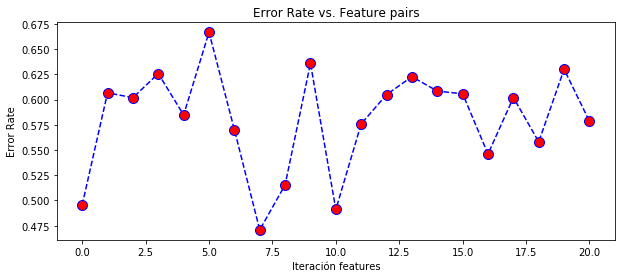

In [43]:
plt.figure(figsize=(10,4))
plt.plot(range(0,len(error_rate_list)), error_rate_list, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Feature pairs')
plt.xlabel('Iteración features')
plt.ylabel('Error Rate')

In [44]:
min_error_index = error_rate_list.index(min(error_rate_list))
min_error = error_rate_list[min_error_index]
print(f"Error min: {min_error}")
features_min_error = features_list[min_error_index]
print(f"Features con error min: {features_min_error}")

Error min: 0.4707949324416171
Features con error min: ['service_0', 'service_1', 'service_2', 'service_3', 'service_4', 'tf_receiver_zipcode']


Luego, encontramos que el par de features que tiene el menor error medio (0.4748) es **service** y **receiver_zipcode**.
Cabe aclarar que la definición de error es totalmente arbitraria (y posiblemente injusta): definimos error como mala estimación (aún cuando haya malas estimaciones -eg: predecir 0-1 días para 2-3 días- y peores estimaciones -eg: predecir 10+ días para 0-1 días-)

#### Entrenamiento con features seleccionados y diferentes valores de N

In [56]:
# Vector de error rate
ns = [1, 10, 50, 100, 500, 750, 1000]
error_rate_list = []
classif_report_list = [] 
conf_matrix_list = [] 
n_list = []
feature_columns = features_min_error
# Variable a predecir
target = 'shipment_days_category'
X_train, X_test, y_train, y_test = preprocess_ds(dataset,feature_columns,target)
for n in ns:
    er_pair,cr_pair,cm_pair = train_knn_model(X_train,X_test,y_train,y_test,n,True)
    error_rate_list.append(er_pair)
    classif_report_list.append(cr_pair)
    conf_matrix_list.append(cm_pair)
    n_list.append(n)

/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 1
Error medio: 0.5520077209580513
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     32267
           1       0.49      0.48      0.48     40378
           2       0.28      0.28      0.28     21491
           3       0.19      0.19      0.19     13862
           4       0.19      0.18      0.18     11090
           5       0.54      0.58      0.56     28044

   micro avg       0.45      0.45      0.45    147132
   macro avg       0.38      0.39      0.39    147132
weighted avg       0.45      0.45      0.45    147132

[[19915  9828  1816   440   113   155]
 [ 9969 19268  7060  2006   725  1350]
 [ 1518  6595  6012  2955  1492  2919]
 [  327  1850  2746  2578  2093  4268]
 [  111   739  1422  1997  2013  4808]
 [  128  1061  2428  3902  4397 16128]]
N: 10
Error medio: 0.4707949324416171
              precision    recall  f1-score   support

           0       0.64      0.75      0.69     32267
           1       0.54      0.58     

Text(0, 0.5, 'Error Rate')

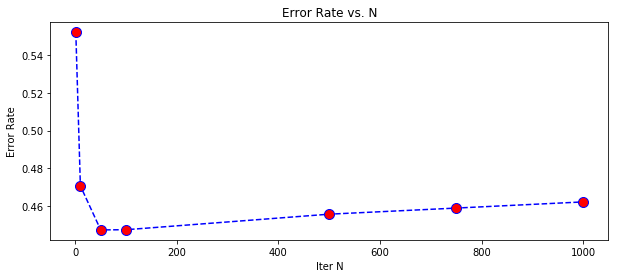

In [59]:
plt.figure(figsize=(10,4))
#plt.plot(range(0,len(error_rate_list)), error_rate_list, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.plot(ns, error_rate_list, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. N')
plt.xlabel('Iter N')
plt.ylabel('Error Rate')

In [47]:
min_error_index = error_rate_list.index(min(error_rate_list))
min_error = error_rate_list[min_error_index]
print(f"Error min: {min_error}")
n_min_error = n_list[min_error_index]
print(f"N con error min: {n_min_error}")

Error min: 0.4475097191637441
N con error min: 50


"Cerca" de N = 50 encontramos el error mínimo para kNN con estos features.

#### Entrenamiento con features y N seleccionados

In [48]:
n_min_error = 50
X_train, X_test, y_train, y_test = preprocess_ds(dataset,features_min_error,target)
error_rate,classif_report,conf_matrix = train_knn_model(X_train,X_test,y_train,y_test,n_min_error,True)

/Users/nsalina/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


N: 50
Error medio: 0.4475097191637441
              precision    recall  f1-score   support

           0       0.67      0.74      0.70     32267
           1       0.55      0.62      0.58     40378
           2       0.39      0.31      0.34     21491
           3       0.27      0.11      0.16     13862
           4       0.30      0.04      0.07     11090
           5       0.56      0.85      0.68     28044

   micro avg       0.55      0.55      0.55    147132
   macro avg       0.46      0.44      0.42    147132
weighted avg       0.51      0.55      0.51    147132

[[23890  8137   186    11     2    41]
 [ 9957 24929  3864   375    47  1206]
 [ 1343  8372  6610  1237   165  3764]
 [  320  2083  3375  1506   370  6208]
 [  114   735  1405  1109   439  7288]
 [  105   757  1583  1240   444 23915]]


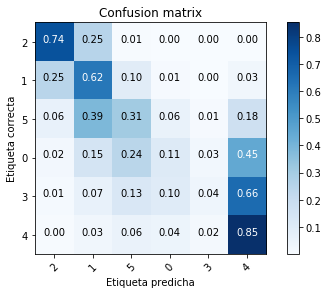

In [49]:
plot_confusion_matrix(conf_matrix,classes,normalize=True)

### Clustering con K-Means

Tomando las conclusiones de la sección anterior, correremos el algoritmo de clusterización K-Means, para distintos parámetros de entrada:

In [50]:
from sklearn.cluster import KMeans

n_init = [1, 5, 10, 50]
max_iter = [10, 100, 300, 500, 1000]
init = ['k-means++', 'random']
tol = [0.1, 0.01, 0.001, 0.0001, 0.00001]
algorithm = ['auto', 'full', 'elkan']

error_rate_list = []
n_init_list = []
max_iter_list = []
init_list = []
tol_list = []
algorithm_list = []

for ni in n_init:
    for mi in max_iter:
        for i in init:
            for t in tol:
                for a in algorithm:
                    kmeans = KMeans(n_clusters=6, n_init=ni, max_iter=mi, init=i, tol=t, algorithm=a).fit(X_train, y_train)
                    new_labels = kmeans.predict(X_test)
                    error_rate_list.append(np.mean(new_labels != y_test))
                    n_init_list.append(ni)
                    max_iter_list.append(mi)
                    init_list.append(i)
                    tol_list.append(t)
                    algorithm_list.append(a)
                    print ("error: %f, ni: %d, mi: %d, i: %s, t: %f, a: %s" % (np.mean(new_labels != y_test), ni, mi, i, t, a))

error: 0.802001, ni: 1, mi: 10, i: k-means++, t: 0.100000, a: auto
error: 0.913445, ni: 1, mi: 10, i: k-means++, t: 0.100000, a: full
error: 0.742048, ni: 1, mi: 10, i: k-means++, t: 0.100000, a: elkan
error: 0.804128, ni: 1, mi: 10, i: k-means++, t: 0.010000, a: auto
error: 0.824593, ni: 1, mi: 10, i: k-means++, t: 0.010000, a: full
error: 0.776588, ni: 1, mi: 10, i: k-means++, t: 0.010000, a: elkan
error: 0.849271, ni: 1, mi: 10, i: k-means++, t: 0.001000, a: auto
error: 0.804285, ni: 1, mi: 10, i: k-means++, t: 0.001000, a: full
error: 0.848633, ni: 1, mi: 10, i: k-means++, t: 0.001000, a: elkan
error: 0.858494, ni: 1, mi: 10, i: k-means++, t: 0.000100, a: auto
error: 0.872828, ni: 1, mi: 10, i: k-means++, t: 0.000100, a: full
error: 0.797597, ni: 1, mi: 10, i: k-means++, t: 0.000100, a: elkan
error: 0.778648, ni: 1, mi: 10, i: k-means++, t: 0.000010, a: auto
error: 0.896807, ni: 1, mi: 10, i: k-means++, t: 0.000010, a: full
error: 0.874365, ni: 1, mi: 10, i: k-means++, t: 0.000010,

error: 0.812006, ni: 1, mi: 1000, i: k-means++, t: 0.010000, a: auto
error: 0.889453, ni: 1, mi: 1000, i: k-means++, t: 0.010000, a: full
error: 0.869478, ni: 1, mi: 1000, i: k-means++, t: 0.010000, a: elkan
error: 0.788510, ni: 1, mi: 1000, i: k-means++, t: 0.001000, a: auto
error: 0.841102, ni: 1, mi: 1000, i: k-means++, t: 0.001000, a: full
error: 0.817232, ni: 1, mi: 1000, i: k-means++, t: 0.001000, a: elkan
error: 0.686193, ni: 1, mi: 1000, i: k-means++, t: 0.000100, a: auto
error: 0.804822, ni: 1, mi: 1000, i: k-means++, t: 0.000100, a: full
error: 0.893429, ni: 1, mi: 1000, i: k-means++, t: 0.000100, a: elkan
error: 0.805209, ni: 1, mi: 1000, i: k-means++, t: 0.000010, a: auto
error: 0.805977, ni: 1, mi: 1000, i: k-means++, t: 0.000010, a: full
error: 0.911542, ni: 1, mi: 1000, i: k-means++, t: 0.000010, a: elkan
error: 0.823709, ni: 1, mi: 1000, i: random, t: 0.100000, a: auto
error: 0.900409, ni: 1, mi: 1000, i: random, t: 0.100000, a: full
error: 0.768276, ni: 1, mi: 1000, i:

error: 0.773496, ni: 5, mi: 500, i: k-means++, t: 0.001000, a: auto
error: 0.740458, ni: 5, mi: 500, i: k-means++, t: 0.001000, a: full
error: 0.790562, ni: 5, mi: 500, i: k-means++, t: 0.001000, a: elkan
error: 0.740689, ni: 5, mi: 500, i: k-means++, t: 0.000100, a: auto
error: 0.915885, ni: 5, mi: 500, i: k-means++, t: 0.000100, a: full
error: 0.846716, ni: 5, mi: 500, i: k-means++, t: 0.000100, a: elkan
error: 0.838213, ni: 5, mi: 500, i: k-means++, t: 0.000010, a: auto
error: 0.703844, ni: 5, mi: 500, i: k-means++, t: 0.000010, a: full
error: 0.839240, ni: 5, mi: 500, i: k-means++, t: 0.000010, a: elkan
error: 0.867548, ni: 5, mi: 500, i: random, t: 0.100000, a: auto
error: 0.816546, ni: 5, mi: 500, i: random, t: 0.100000, a: full
error: 0.791106, ni: 5, mi: 500, i: random, t: 0.100000, a: elkan
error: 0.940040, ni: 5, mi: 500, i: random, t: 0.010000, a: auto
error: 0.819468, ni: 5, mi: 500, i: random, t: 0.010000, a: full
error: 0.873603, ni: 5, mi: 500, i: random, t: 0.010000, a:

error: 0.802205, ni: 10, mi: 300, i: k-means++, t: 0.001000, a: elkan
error: 0.872319, ni: 10, mi: 300, i: k-means++, t: 0.000100, a: auto
error: 0.813181, ni: 10, mi: 300, i: k-means++, t: 0.000100, a: full
error: 0.796496, ni: 10, mi: 300, i: k-means++, t: 0.000100, a: elkan
error: 0.835631, ni: 10, mi: 300, i: k-means++, t: 0.000010, a: auto
error: 0.828181, ni: 10, mi: 300, i: k-means++, t: 0.000010, a: full
error: 0.707562, ni: 10, mi: 300, i: k-means++, t: 0.000010, a: elkan
error: 0.887999, ni: 10, mi: 300, i: random, t: 0.100000, a: auto
error: 0.786036, ni: 10, mi: 300, i: random, t: 0.100000, a: full
error: 0.878082, ni: 10, mi: 300, i: random, t: 0.100000, a: elkan
error: 0.780564, ni: 10, mi: 300, i: random, t: 0.010000, a: auto
error: 0.944676, ni: 10, mi: 300, i: random, t: 0.010000, a: full
error: 0.847450, ni: 10, mi: 300, i: random, t: 0.010000, a: elkan
error: 0.903658, ni: 10, mi: 300, i: random, t: 0.001000, a: auto
error: 0.849502, ni: 10, mi: 300, i: random, t: 0.

error: 0.788442, ni: 50, mi: 100, i: k-means++, t: 0.000100, a: auto
error: 0.807010, ni: 50, mi: 100, i: k-means++, t: 0.000100, a: full
error: 0.875411, ni: 50, mi: 100, i: k-means++, t: 0.000100, a: elkan
error: 0.806793, ni: 50, mi: 100, i: k-means++, t: 0.000010, a: auto
error: 0.813290, ni: 50, mi: 100, i: k-means++, t: 0.000010, a: full
error: 0.712911, ni: 50, mi: 100, i: k-means++, t: 0.000010, a: elkan
error: 0.843902, ni: 50, mi: 100, i: random, t: 0.100000, a: auto
error: 0.839518, ni: 50, mi: 100, i: random, t: 0.100000, a: full
error: 0.899655, ni: 50, mi: 100, i: random, t: 0.100000, a: elkan
error: 0.862192, ni: 50, mi: 100, i: random, t: 0.010000, a: auto
error: 0.829323, ni: 50, mi: 100, i: random, t: 0.010000, a: full
error: 0.798018, ni: 50, mi: 100, i: random, t: 0.010000, a: elkan
error: 0.804380, ni: 50, mi: 100, i: random, t: 0.001000, a: auto
error: 0.819142, ni: 50, mi: 100, i: random, t: 0.001000, a: full
error: 0.902312, ni: 50, mi: 100, i: random, t: 0.0010

In [51]:
min_error_index = error_rate_list.index(min(error_rate_list))
print ("Error min: %f (ni: %d, mi: %d, i: %s, t: %f, a: %s)" % (error_rate_list[min_error_index], n_init_list[min_error_index], max_iter_list[min_error_index], init_list[min_error_index], tol_list[min_error_index], algorithm_list[min_error_index]))

Error min: 0.619627 (ni: 10, mi: 500, i: random, t: 0.010000, a: full)


Esto es apenas mejor que random (0.833), pero un baseline para continuar con el trabajo.